In [579]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
# Magics
%matplotlib inline

# Paquetes

In [45]:
from __future__ import division, print_function

import json
import math
import os
# utils
import pickle
import time

import fiona  # for reading and writing shapefiles
# GIS libs
import folium
import folium.plugins
import geopandas as gpd
import matplotlib.pyplot as plt
# Stats
import pandas as pd
# Web
import requests
# visualization
import seaborn as sns
from matplotlib.colors import ListedColormap
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from shapely.geometry import Point
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_curve, auc)

sns.set()


def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    """
    Source: https://www.peterbe.com/plog/best-practice-with-retries-with-requests
    """
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [25]:
# cargamos el mapa de IUCN
iucn_shp = gpd.read_file(
    'data/IUCN/TERRESTRIAL_MAMMALS/TERRESTRIAL_MAMMALS.shp')

# Definición de funciones

In [1]:
api_url = 'http://species.conabio.gob.mx/api/niche'

## get_species_data

In [3]:
def get_species_data(api_url, name, analysis_res=16):
    """ Regresa un dataframe con la información taxonomica de una especie y su id en la base de datos  """
    query = {
        "searchStr": name,  # Nombre de la especie substring de la especie a buscar
        "source": 1,
        "limit": "true",
        "grid_res": 16
    }
    r = requests.post(api_url+'/especie/getEntList', params=query)

    response = json.loads(r.content)
    return pd.DataFrame(response['data'])

## get_taxon_points

In [200]:
def get_taxon_points(api_url, name, analysis_res=16):
    df = get_species_data(api_url, name)
    sp_id = df.spid
    endpoint = 'especie/getSpecies'
    params = {
        "id": "{}".format(sp_id[0]),
        "lim_inf": "1940",
        "lim_sup": "2020",
        "idtime": "1525302357735",
        "fossil": "false",
        "sfecha": "false",
        "grid_res": analysis_res,
    }

    query = api_url + "/{}".format(endpoint)
    r = requests_retry_session(retries=10).post(query, params, timeout=200)

    data = r.json()
    data = gpd.GeoDataFrame(data['data'])
    
    if not data.empty:
        data['geometry'] = data.json_geom.apply(
            lambda x: json.loads(x)['coordinates'])
        data['geometry'] = data.geometry.apply(Point)
        data = data.set_geometry('geometry')

    return data

### Ejemplo

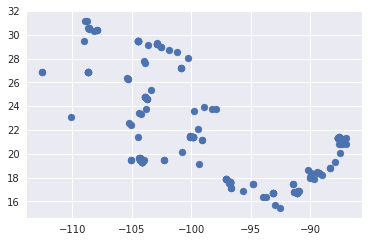

In [5]:
points = get_taxon_points(api_url, 'Puma concolor')

points.plot()

## get_sdm
Obtener un modelo de distribución utilizando el API de SPECIES

In [73]:
def get_sdm(api_url, sp_id, analysis_res=32, bioclim_groups={}, biotic_groups={}, mapa_prob=False, verbose=False):
    endpoint = 'getCellScore'
    has_raster = 'false'
    has_bios = 'false'

    params = {
        "id": "{}".format(sp_id),
        "lim_inf": "1940",
        "lim_sup": "2020",
        "idtime": "1525302357735",
        "apriori": "apriori",
        "min_occ": "5",
        "fossil": "false",
        "sfecha": "false",
        "val_process": "false",
        "idtabla": "no_table",
        "grid_res": "{}".format(analysis_res),
    }

    if mapa_prob:
        params.update({'mapa_prob': 'mapa_prob'})

    if bioclim_groups:
        has_raster = 'true'
        for i, k in enumerate(bioclim_groups.keys()):
            value = bioclim_groups[k]
            abio_type = str(0)
            abio_level = str(0)
            abio_label = k
            params.update({
                "tfilters[{}][value]".format(i): value,
                "tfilters[{}][type]".format(i): abio_type,
                "tfilters[{}][level]".format(i): abio_level,
                "tfilters[{}][label]".format(i): abio_label,
            })
    if biotic_groups:
        offset = len(bioclim_groups)
        has_bios = 'true'

        for i, k in enumerate(biotic_groups.keys()):
            index = i + offset
            field = biotic_groups[k]
            value = k
            bio_type = str(4)
            params.update({
                "tfilters[{}][field]".format(index): field,
                "tfilters[{}][value]".format(index): value,
                "tfilters[{}][type]".format(index): bio_type
            })
    params.update({
        "hasBios": has_bios,
        "hasRaster": has_raster
    })

    query = api_url + "/{}".format(endpoint)
    r = requests_retry_session(retries=10).post(query, params, timeout=200)

    data = json.loads(r.content)
    data = data['data']

    data = pd.DataFrame(data)
    if data.empty:
        print('No data')
    else:
        data.tscore = pd.to_numeric(data.tscore)

    return data

## evaluate_sdms

Esta función obtiene modelos de distribución para las especies $e_i$, donde $i$ es tal que $start \leq i \lt end$, y etiqueta cada resultado como 'True possitive', 'True negative', 'False possitive', ó, 'False negative' de acuerdo a los  modelos de distribución de referencia (**sp_cells**).

In [65]:
def evaluate_sdms(api_url, sp_cells, grid,
                  analysis_res=64, start=0, end=20,
                  bioclim_groups={}, biotic_groups={},
                  verbose=False,
                  checkpoints_frq=None, checkpoints_prefix='', load_check=None):
    iter_count = 0
    sp_dfs = {}
    labels = {
        0: 'True negative',
        1: 'False possitive',
        2: 'False negative',
        3: 'True possitive'
    }
    prev_checkpoint = None

    if load_check:
        saved_checkpoint = "{}sdms_dict_{}.pkl".format(
            checkpoints_prefix, load_check)
        with open(saved_checkpoint, 'rb') as in_file:
            sp_dfs = pickle.load(in_file)
            print("{} species loaded.....".format(len(sp_dfs)))
            prev_checkpoint = saved_checkpoint
    try:
        for name, group in sp_cells:
            if iter_count >= end:
                break

            iter_count += 1
            if sp_dfs.has_key(name):
                print('Skipping ', name)
            else:
                if verbose:
                    print(name)

                truth = group
                species_data = get_species_data(api_url, name, analysis_res)

                if {'spid'}.issubset(species_data.columns):
                    spid = species_data['spid'][0]
                    sdm = get_sdm(api_url,
                                  spid,
                                  analysis_res=analysis_res,
                                  bioclim_groups=bioclim_groups,
                                  biotic_groups=biotic_groups,
                                  verbose=verbose)

                    if not sdm.empty:
                        sdm = grid.merge(sdm, on='gridid')
                        sdm['species'] = name

                        sdm_eval = sdm.merge(
                            truth[['gridid', 'presence']], on='gridid', how='left')
                        if {'tscore'}.issubset(sdm_eval.columns):
                            sdm_eval['presence'] = sdm_eval['presence'].fillna(
                                0).astype(int)
                            sdm_eval['pred'] = 0
                            sdm_eval.loc[sdm_eval['tscore'] >= 0, 'pred'] = 1
                            sdm_eval.loc[sdm_eval.presence > 2, 'presence'] = 0
                            sdm_eval.loc[sdm_eval.presence ==
                                         2, 'presence'] = 1
                            sdm_eval['confussion'] = 2 * \
                                sdm_eval['presence'] + sdm_eval['pred']
                            sdm_eval['confussion_labels'] = [labels[conf_val]
                                                             for conf_val in sdm_eval['confussion']]
                            sp_dfs[name] = sdm_eval

                            if checkpoints_frq and len(sp_dfs) % checkpoints_frq == 0:
                                print("Num. Especies: ", len(sp_dfs))
                                new_checkpoint = '{}sdms_dict_{}.pkl'.format(
                                    checkpoints_prefix, len(sp_dfs))

                                with open(new_checkpoint, 'wb') as out_file:
                                    pickle.dump(sp_dfs, out_file,
                                                pickle.HIGHEST_PROTOCOL)
                                if prev_checkpoint and os.path.exists(prev_checkpoint):
                                    os.remove(prev_checkpoint)
                                prev_checkpoint = new_checkpoint
                    else:
                        # if empty
                        sp_dfs[name] = pd.DataFrame()

    except requests.exceptions.RequestException as err:
        print("Error de conexión: ", err)
        return pd.concat(sp_dfs)
    finally:
        print("Final Num. Especies: ", len(sp_dfs))
        new_checkpoint = '{}sdms_dict_{}.pkl'.format(
            checkpoints_prefix, len(sp_dfs))

        with open(new_checkpoint, 'wb') as out_file:
            pickle.dump(sp_dfs, out_file, pickle.HIGHEST_PROTOCOL)

    return pd.concat(sp_dfs)

## get_grid_iucn_intersection

In [806]:
def get_grid_iucn_intersection(grid_dir, analysis_res, iucn_shp):
    grid_path = os.path.join(
        grid_dir, "mx_grid_{}km.json".format(analysis_res))
    grid = gpd.read_file(grid_path)

    presence_cells = gpd.sjoin(iucn_shp, grid, how='right', op='intersects')
    sp_cells = presence_cells

    return sp_cells

## print_eval_stats
Para evaluar el desempeño reportamos la precisión, cobertura, exactitud y score F1. Las definiciones de estas estadísticas son:

Sean
* $tp$ los verdaderos positivos
* $tn$ los verdaderos negativos
* $fp$ los falsos positivos
* $fn$ los falsos negativos

entonces definimos la precisión, el recall, la exactitud (accuracy), y el score f1 de la siguiente manera:

$$
\begin{align}
precision &= \frac{tp}{tp + fp} \\
recall &= \frac{tp}{tp + fn} \\
accuracy &= \frac{tp + tn}{tp + fp + tn + fn} \\
f1 &= \frac{2}{\frac{1}{precision} + \frac{1}{recall}}
\end{align}
$$

In [9]:
def print_eval_stats(sdms_df):
    fig = print_confusion_matrix(confusion_matrix(
        sdms_df.presence, sdms_df.pred), class_names=[0, 1])
    plt.show(fig)
    print('Accuracy: ', accuracy_score(sdms_df.presence, sdms_df.pred))
    print('F1 score: ', f1_score(sdms_df.presence, sdms_df.pred))
    print('Recall: ', recall_score(sdms_df.presence, sdms_df.pred))
    print('Precision: ', precision_score(sdms_df.presence, sdms_df.pred))
    print('\n clasification report: \n', classification_report(
        sdms_df.presence, sdms_df.pred))

    stats = get_stats_per_species(sdms_df)
    df = pd.DataFrame(stats)
    df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=[
                      'estadistica'], value_name='valor')
    g = sns.FacetGrid(df_test, col='estadistica', size=4)
    g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)

## plot_confussion_maps

In [ ]:
def plot_confussion_maps(sdms_df, num_plots, title=''):
    flatui = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    nrows = num_plots // 3
    f, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows*4))
    sp_grp = sdms_df.groupby('species')

    axes = axes.flat
    ax_num = 0

    for name, grp in sp_grp:
        if ax_num >= len(axes):
            break
        ax = axes[ax_num]
        ax_num += 1
        acc = accuracy_score(grp.presence, grp.pred)
        f1 = f1_score(grp.presence, grp.pred)
        recall = recall_score(grp.presence, grp.pred)
        prec = precision_score(grp.presence, grp.pred)
        ax.set_title('{} {}: acc={}, f1={}, r={}, p={}'.format(
            title, name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")

        grp.plot(ax=ax,
                 column='confussion_labels',
                 alpha=0.9,
                 edgecolor='w',
                 legend=True,
                 categorical=True,
                 cmap=my_cmap)
        ax.set_axis_off()

    f.tight_layout()
    return f

## plot_confusion_map

In [1104]:
def plot_confusion_map(sp_model, ax, name='', title='', confussion_col='confussion_labels', pred_col='pred', presence_col='presence'):
    flatui = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    acc = accuracy_score(sp_model[presence_col], sp_model[pred_col])
    f1 = f1_score(sp_model[presence_col], sp_model[pred_col])
    recall = recall_score(sp_model[presence_col], sp_model[pred_col])
    prec = precision_score(sp_model[presence_col], sp_model[pred_col])
    ax.set_title('{} {}: acc={}, f1={}, r={}, p={}'.format(
        title, name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")

    sp_model.plot(ax=ax,
                  column=confussion_col,
                  alpha=0.9,
                  edgecolor='w',
                  legend=True,
                  categorical=True,
                  cmap=my_cmap)

    points = get_taxon_points(api_url, name)
    points.plot(ax=ax, color='black', markersize=15, edgecolor='white')
    ax.set_axis_off()

### Ejemplo

In [ ]:
bioclim_groups = {'Bioclim': 'root_bioclim'}
sdms_abio_df = full_analysis(analysis_res=8,
                             truth_shape=iucn_shp,
                             bioclim_groups=bioclim_groups,
                             checkpoints_prefix='bioclim_{}_'.format(8))

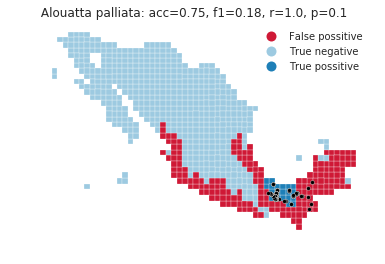

In [27]:
f, ax = plt.subplots(1, figsize=(6, 4))
species_sdm = sdms_abio_df.groupby('species')
species_sdm = species_sdm.get_group('Alouatta palliata')
plot_confusion_map(species_sdm, name='Alouatta palliata', ax=ax)

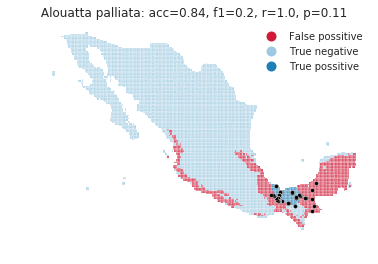

In [29]:
f, ax = plt.subplots(1, figsize=(6, 4))
species_sdm = sdms_abio_df.groupby('species')
species_sdm = species_sdm.get_group('Alouatta palliata')
plot_confusion_map(species_sdm, name='Alouatta palliata', ax=ax)

## plot_maps_comparision

Esta función presenta lado a lado los mapas de uno y otro modelo. Los mapas que se presentan son una selección utilizando el score f1 de una de los modelos. En concreto, la función obtiene los mejores, los peores y los modelos intermedios del modelo *sort_by_model* y muestra los mapas correspondientes, para el modelo elejido y los otros modelos.

In [16]:
def plot_maps_comparision(results, sort_by_model=0):
    ref_model = results[sort_by_model]
    stats = get_stats_per_species(ref_model, min_occ=5)
    stats_df = pd.DataFrame(stats)
    quant_size = 0.1

    low, mid_0, mid_1, top = stats_df.f1.quantile(
        [quant_size, 0.5, 0.5 + quant_size, 1 - quant_size])

    low_f1_sp = stats_df[stats_df.f1 <= low].sort_values(
        by='f1', ascending=True).iloc[:4]
    mid_f1_sp = stats_df[stats_df.f1.between(mid_0, mid_1)].sort_values(
        by='f1', ascending=True).iloc[:4]
    top_f1_sp = stats_df[stats_df.f1 >= top].sort_values(
        by='f1', ascending=False).iloc[:4]

    flatui = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    nrows = 3
    ncols = len(results)

    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ref_grouping = ref_model.groupby('species')
    other_models_grps = [model.groupby(
        'species') for i, model in enumerate(results) if i != sort_by_model]

    axes = axes.flat
    ax_num = 0

    # Plot worst performance maps
    for name in low_f1_sp.name:
        ref_group = ref_grouping.get_group(name)

        if ax_num >= len(axes):
            break

        ax = axes[ax_num]
        ax_num += 1
        plot_confusion_map(ref_group, ax, name=name, title="Worst")

        for model in other_models_grps:
            if ax_num >= len(axes):
                break

            ax = axes[ax_num]
            ax_num += 1

            if name in model.groups.keys():
                grp = model.get_group(name)
                plot_confusion_map(grp, ax, name=name, title="Worst")
    f.tight_layout()

    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))

    axes = axes.flat
    ax_num = 0

    # Plot middle performance maps
    for name in mid_f1_sp.name:
        ref_group = ref_grouping.get_group(name)

        if ax_num >= len(axes):
            break

        ax = axes[ax_num]
        ax_num += 1
        plot_confusion_map(ref_group, ax, name=name, title="Middle")

        for model in other_models_grps:
            if ax_num >= len(axes):
                break

            ax = axes[ax_num]
            ax_num += 1

            grp = model.get_group(name)
            plot_confusion_map(grp, ax, name=name, title="Middle")

    f.tight_layout()

    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))

    axes = axes.flat
    ax_num = 0
    # Plot best performance maps
    for name in top_f1_sp.name:
        ref_group = ref_grouping.get_group(name)

        if ax_num >= len(axes):
            break

        ax = axes[ax_num]
        ax_num += 1
        plot_confusion_map(ref_group, ax, name=name, title="Best")

        for model in other_models_grps:
            if ax_num >= len(axes):
                break

            ax = axes[ax_num]
            ax_num += 1

            grp = model.get_group(name)
            plot_confusion_map(grp, ax, name=name, title="Best")
    f.tight_layout()

    plt.show()

In [ ]:
biotic_groups = {'Animalia': 'reinovalido', 'Plantae': 'reinovalido'}
analysis_res = 64
sdms_plant_anim_df = full_analysis(analysis_res=analysis_res,
                                   truth_shape=iucn_shp,
                                   bioclim_groups=bioclim_groups,
                                   biotic_groups=biotic_groups,
                                   checkpoints_prefix='bioclim_snib_{}_'.format(
                                       analysis_res),
                                   verbose=True,
                                   load_check=398,
                                   n=398)

plot_maps_comparision([sdms_abio_df, sdms_plant_anim_df], sort_by_model=1)

## plot_bottom_mid_top_maps

In [17]:
def plot_bottom_mid_top_maps(smds_df, quant_size):
    stats = get_stats_per_species(smds_df)
    stats_df = pd.DataFrame(stats)

    low, mid_0, mid_1, top = stats_df.f1.quantile(
        [quant_size, 0.5, 0.5 + quant_size, 1 - quant_size])

    low_f1_sp = stats_df[stats_df.f1 <= low]
    mid_f1_sp = stats_df[stats_df.f1.between(mid_0, mid_1)]
    top_f1_sp = stats_df[stats_df.f1 >= top]

    plot_confussion_maps(
        smds_df[smds_df.species.isin(low_f1_sp.name)], 6, 'Lowest f1')
    plot_confussion_maps(
        smds_df[smds_df.species.isin(mid_f1_sp.name)], 6, 'Middle f1')
    plot_confussion_maps(
        smds_df[smds_df.species.isin(top_f1_sp.name)], 6, 'Top f1')

## get_stats_per_species

In [18]:
def get_stats_per_species(sdms_df, min_occ=0):
    stats = []
    sp_grp = sdms_df.groupby('species')
    for name, grp in sp_grp:
        if grp.presence.sum() >= min_occ:
            acc = accuracy_score(grp.presence, grp.pred)
            f1 = f1_score(grp.presence, grp.pred)
            recall = recall_score(grp.presence, grp.pred)
            prec = precision_score(grp.presence, grp.pred)

            stats.append({'acc': acc, 'f1': f1, 'recall': recall,
                          'precision': prec, 'name': name})
    return stats

## full_analysis

In [19]:
def full_analysis(analysis_res,
                  truth_shape,
                  n=None,
                  grid_dir='grids/',
                  bioclim_groups={},
                  biotic_groups={},
                  verbose=False,
                  checkpoints_frq=None,
                  checkpoints_prefix='',
                  load_check=None,
                  graphics=False,
                  map_prob=''):

    grid_path = os.path.join(
        grid_dir, "mx_grid_{}km.json".format(analysis_res))
    grid = gpd.read_file(grid_path)

    # obtener grid con la resolucion que se necesita e intersecar grid con modelos de iucn
    sp_cells = get_grid_iucn_intersection(grid_dir, analysis_res, truth_shape)

    if not n:
        n = len(sp_cells)
    if checkpoints_frq < 0:
        checkpoints_frq = None

    sdms_df = evaluate_sdms(api_url, sp_cells, grid,
                            analysis_res, start=0, end=n,
                            bioclim_groups=bioclim_groups,
                            biotic_groups=biotic_groups,
                            verbose=verbose,
                            checkpoints_frq=checkpoints_frq,
                            checkpoints_prefix=checkpoints_prefix,
                            load_check=load_check,
                            map_prob='')

    if graphics:
        print_eval_stats(sdms_df)
        plot_confussion_maps(sdms_df, 20)

    return sdms_df

## get_comparison_sdms

In [20]:
def get_comparison_sdms(analysis_res, load_bioclim_check=None, load_plant_anim_check=None):
    checkpoints_frq = 5

    bioclim_groups = {'Bioclim': 'root_bioclim'}
    sdms_abio_df = full_analysis(analysis_res=analysis_res,
                                 truth_shape=iucn_shp,
                                 bioclim_groups=bioclim_groups,
                                 checkpoints_frq=checkpoints_frq,
                                 checkpoints_prefix='bioclim_{}_'.format(
                                     analysis_res),
                                 load_check=load_bioclim_check)

#    biotic_groups = {'Plantae': 'reinovalido'}
#    sdms_plantae_df = full_analysis(analysis_res = analysis_res,
#                                    truth_shape = iucn_shp,
#                                    bioclim_groups = bioclim_groups,
#                                    biotic_groups = biotic_groups,
#                                    verbose = True)

    biotic_groups = {'Animalia': 'reinovalido', 'Plantae': 'reinovalido'}
    sdms_plant_anim_df = full_analysis(analysis_res=analysis_res,
                                       truth_shape=iucn_shp,
                                       bioclim_groups=bioclim_groups,
                                       biotic_groups=biotic_groups,
                                       checkpoints_frq=checkpoints_frq,
                                       checkpoints_prefix='bioclim_snib_{}_'.format(
                                           analysis_res),
                                       load_check=load_plant_anim_check)

    return sdms_abio_df, sdms_plant_anim_df

## compare_eval_stats

In [21]:
def compare_eval_stats(results):
    for i, sdms_df in enumerate(results):
        title = 5*'-' + "Model {} " + 20*'-'
        fig = print_confusion_matrix(confusion_matrix(
            sdms_df.presence, sdms_df.pred), class_names=[0, 1])
        plt.show(fig)

        print(title.format(i))
        print('Accuracy: {}'.format(accuracy_score(sdms_df.presence, sdms_df.pred)))
        print('F1 score: {}'.format(f1_score(sdms_df.presence, sdms_df.pred)))
        print('Recall: {}'.format(recall_score(sdms_df.presence, sdms_df.pred)))
        print('Precision: {}'.format(
            precision_score(sdms_df.presence, sdms_df.pred)))
        print('\n clasification report: \n{}'.format(
            classification_report(sdms_df.presence, sdms_df.pred)))

    for i, sdms_df in enumerate(results):
        title = 5*'-' + "Model {} " + 20*'-'
        print(title.format(i))
        stats = get_stats_per_species(sdms_df)
        df = pd.DataFrame(stats)
        df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=[
                          'estadistica'], value_name='valor')
        g = sns.FacetGrid(df_test, col='estadistica', size=4)
        g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)
        plt.show()

## print_confusion_matrix
Fuente: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

In [22]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## plot_roc

In [84]:
def plot_roc(sdms_df, title):
    fpr, tpr, thresholds = roc_curve(sdms_df.presence, y_score=sdms_df.tscore)
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.suptitle('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

## plot_rocs_var

In [778]:
def plot_rocs_var(sdms_df, title, truth_col='presence', prediction_col='tscore'):
    # mapear ocurrencias, auc, 
    mean_fpr, mean_tpr, mean_thresholds = roc_curve(sdms_df.presence, y_score=sdms_df.tscore)
    roc_auc = auc(mean_fpr, mean_tpr)

    plt.title(title)
    plt.suptitle('Receiver Operating Characteristic')
    
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    rocs_df = pd.DataFrame(columns=['fpr', 'tpr', 'threshold'])
    for species, sdm in sdms_df.groupby('species'):
        fpr, tpr, thresholds = roc_curve(sdm.presence, y_score=sdm.tscore)
        sp_info = get_taxon_points(api_url=api_url, analysis_res=analysis_res, name=species)
        if not sp_info.empty:
            sp_occ = sp_info.occ.unique()[0]

            plt.plot(fpr, tpr, color='#9ecae1', alpha=0.1)
    
    plt.plot(mean_fpr, mean_tpr, 'b',
         label='AUC = %0.2f' % roc_auc)

    plt.show()

## get_auc_occ_df

In [914]:
def get_auc_occ_df(df, analysis_res, truth_col='presence'):
    vals_dicts = []
    
    for species, sdm in df.groupby('species'):
        sp_info = get_taxon_points(api_url=api_url, analysis_res=analysis_res, name=species)
        iucn_cells = sdm[truth_col].sum()
        if not sp_info.empty and iucn_cells > 0:
            fpr, tpr, thresholds = roc_curve(sdm[truth_col], y_score=sdm.tscore)
            sp_auc = auc(fpr, tpr)
            sp_occ = sp_info.occ.unique()[0]
            
            if not np.any(np.isnan([sp_auc, sp_occ, iucn_cells])):            
                vals_dicts.append({'name': species, 'auc': sp_auc, 'occ': sp_occ, 'iucn_cells': iucn_cells})
    
    df = pd.DataFrame(vals_dicts)
    return df

## plot_pairdist_auc_occ

In [163]:
def plot_pairdist_auc_occ(sdms_df, title, analysis_res=16):
    df = get_auc_occ_df(sdms_df, analysis_res)

    sns.jointplot(df, x='occ', y='auc', dropna=True)
    plt.show()

# ROC a 64km

In [66]:
analysis_res = 64
bioclim_groups = {'Bioclim': 'root_bioclim'}
sdms64_abio_df = full_analysis(analysis_res=analysis_res,
                             truth_shape=iucn_shp,
                             bioclim_groups=bioclim_groups,
                             checkpoints_prefix='bioclim_score_{}_'.format(analysis_res))

No data
Final Num. Especies:  448


/LUSTRE/users/rsierra/envs/species_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [67]:
analysis_res = 32
sdms32_abio_df = full_analysis(analysis_res=analysis_res,
                             truth_shape=iucn_shp,
                             bioclim_groups=bioclim_groups,
                             checkpoints_prefix='bioclim_score_{}_'.format(analysis_res))

No data
Final Num. Especies:  447


/LUSTRE/users/rsierra/envs/species_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [75]:
analysis_res = 16
sdms16_abio_df = full_analysis(analysis_res=analysis_res,
                             truth_shape=iucn_shp,
                             bioclim_groups=bioclim_groups,
                             checkpoints_prefix='bioclim_score_{}_'.format(analysis_res))

No data
Final Num. Especies:  447


/LUSTRE/users/rsierra/envs/species_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [76]:
analysis_res = 8
sdms8_abio_df = full_analysis(analysis_res=analysis_res,
                             truth_shape=iucn_shp,
                             bioclim_groups=bioclim_groups,
                             checkpoints_prefix='bioclim_score_{}_'.format(analysis_res))

No data
Final Num. Especies:  446


/LUSTRE/users/rsierra/envs/species_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



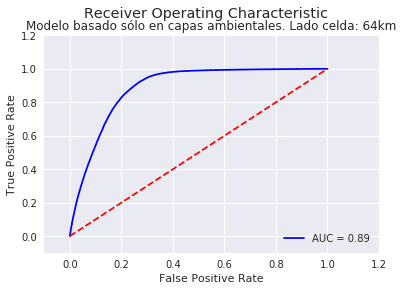

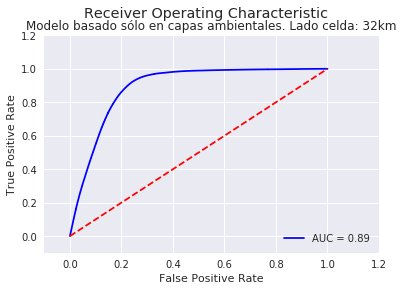

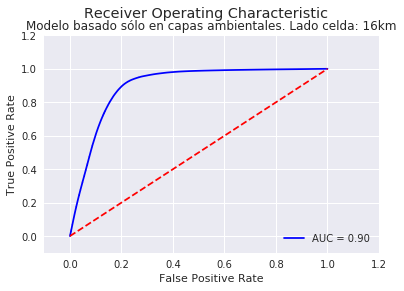

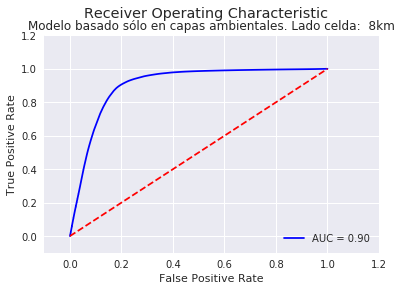

In [86]:
plot_roc(sdms64_abio_df, u"Modelo basado sólo en capas ambientales. Lado celda: 64km")
plot_roc(sdms32_abio_df, u"Modelo basado sólo en capas ambientales. Lado celda: 32km")
plot_roc(sdms16_abio_df, u"Modelo basado sólo en capas ambientales. Lado celda: 16km")
plot_roc(sdms8_abio_df, u"Modelo basado sólo en capas ambientales. Lado celda:  8km")

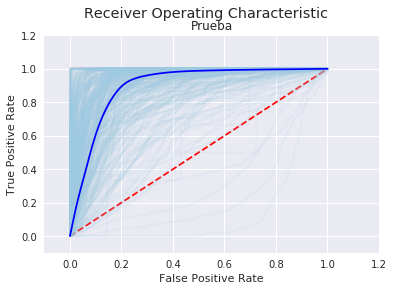

In [249]:
plot_rocs_var(sdms16_abio_df, 'Prueba')

In [162]:
plot_pairdist_auc_occ(sdms16_abio_df, analysis_res=16, title='prueba')

        auc                        name  occ
0  0.979909           Alouatta palliata   52
1  0.885501   Ammospermophilus harrisii   26
2  0.976575  Ammospermophilus interpres   13
3  0.983335   Ammospermophilus leucurus  151
4  0.942401            Anoura geoffroyi  266


TypeError: jointplot() got multiple values for keyword argument 'x'

In [519]:
df = get_auc_occ_df(sdms16_abio_df, analysis_res)

In [512]:
df.head()

,auc,iucn_cells,name,occ,log(occ),log(auc)
0,0.979909,195.0,Alouatta palliata,57,5.832890,5.636586
1,0.885501,508.0,Ammospermophilus harrisii,28,4.807355,3.126479
2,0.976575,895.0,Ammospermophilus interpres,16,4.000000,5.415206
3,0.983335,766.0,Ammospermophilus leucurus,181,7.499846,5.906163
4,0.942401,3321.0,Anoura geoffroyi,348,8.442943,4.117571


In [216]:
df.head()

,auc,name,occ
0,0.979909,Alouatta palliata,57
1,0.885501,Ammospermophilus harrisii,28
2,0.976575,Ammospermophilus interpres,16
3,0.983335,Ammospermophilus leucurus,181
4,0.942401,Anoura geoffroyi,348


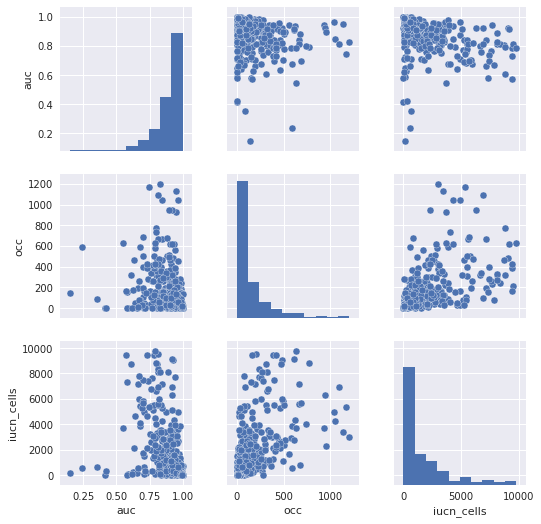

In [520]:
sns.pairplot(df, vars=['auc', 'occ', 'iucn_cells'])

In [486]:
from scipy import stats
import numpy as np
from matplotlib import ticker as tck

In [531]:
df['log(occ)'] = np.log2(df.occ)
df['log(auc)'] = -np.log2(1 - 0.99999*df.auc)

In [507]:
? np.log

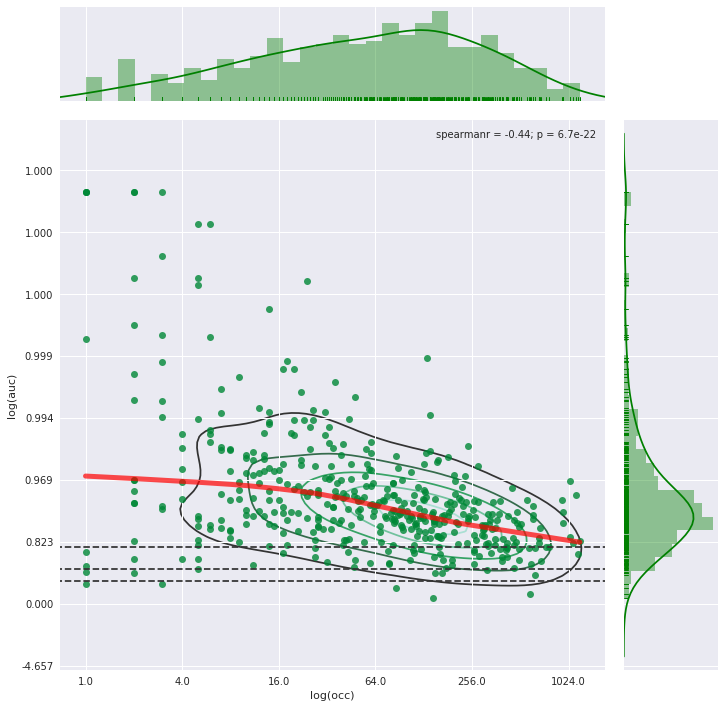

In [537]:
g = sns.JointGrid(x="log(occ)", y='log(auc)', data=df, size=10, )
g = g.plot_joint(sns.regplot,
                 color="#008837", scatter=True, n_boot=25, lowess=True,
                 line_kws={"color": "r", "alpha": 0.7, "lw": 5,
                           'label': 'Locally Weighted Linear Regression'})
plt.plot((-1, 12), (-np.log(1 - 0.9), -np.log(1 - 0.9)), c=".2", ls="--")
plt.plot((-1, 12), (-np.log(1 - 0.75), -np.log(1 - 0.75)), c=".2", ls="--")
plt.plot((-1, 12), (-np.log(1 - 0.6), -np.log(1 - 0.6)), c=".2", ls="--")

g = g.plot_joint(sns.kdeplot, zorder=0, n_levels=5)
g = g.plot_marginals(sns.distplot, kde=True, color="g", rug=True, bins=30)

g.ax_joint.xaxis.set_major_formatter(
    tck.FuncFormatter(lambda x, pos: '{:0.1f}'.format(2**x)))

g.ax_joint.yaxis.set_major_formatter(
    tck.FuncFormatter(lambda x, pos: '{:0.3f}'.format((1 - 2**(-x)) / 0.99999)))

g.ax_joint.legend()
g = g.annotate(stats.spearmanr)

In [515]:
df[df.iucn_cells == 0]

,auc,iucn_cells,name,occ,log(occ),log(auc),log(iucn)
289,NaN,0.0,Peromyscus guardia,7,2.807355,NaN,-inf


In [521]:
df['log(iucn)'] = np.log2(df.iucn_cells)
df['log(auc)'] = -np.log2(1 - 0.99999*df.auc)

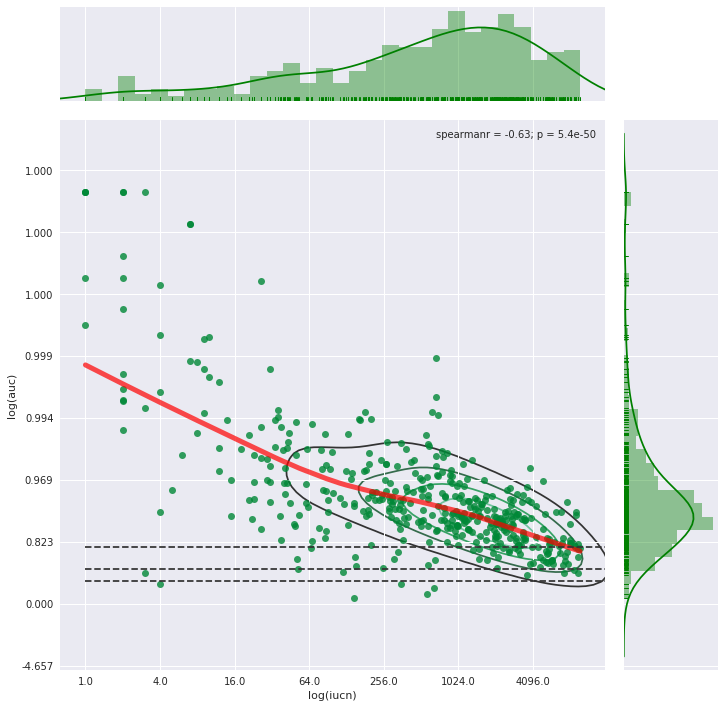

In [529]:
g = sns.JointGrid(x="log(iucn)", y='log(auc)', data=df, size=10, )
g = g.plot_joint(sns.regplot,
                 color="#008837", scatter=True, n_boot=25, lowess=True,
                 line_kws={"color": "r", "alpha": 0.7, "lw": 5,
                           'label': 'Locally Weighted Linear Regression'})
g = g.plot_joint(sns.kdeplot, zorder=0, n_levels=5)

plt.plot((0, 50), (-np.log(1 - 0.9), -np.log(1 - 0.9)), c=".2", ls="--")
plt.plot((0, 50), (-np.log(1 - 0.75), -np.log(1 - 0.75)), c=".2", ls="--")
plt.plot((0, 50), (-np.log(1 - 0.6), -np.log(1 - 0.6)), c=".2", ls="--")

g = g.plot_marginals(sns.distplot, kde=True, color="g", rug=True, bins=30)

g.ax_joint.xaxis.set_major_formatter(
    tck.FuncFormatter(lambda x, pos: '{:0.1f}'.format(2**x)))

g.ax_joint.yaxis.set_major_formatter(
    tck.FuncFormatter(lambda x, pos: '{:0.3f}'.format((1 - 2**(-x)) / 0.99999)))

g.ax_joint.legend()
g = g.annotate(stats.spearmanr)

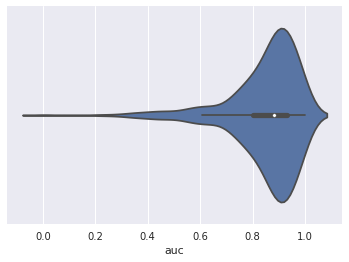

In [569]:
sns.violinplot(df['auc'], inner='box')

# ROCs con SNIB y Bioclim a 8km

In [587]:
analysis_res = 16

In [589]:
auc16_abio_df = get_auc_occ_df(sdms16_abio_df, analysis_res)

In [590]:
with open('bioclim_snib_16_test_score_sdms_dict_447.pkl', 'rb') as f:
    sdms_snib_16 = pickle.load(f)
    

In [591]:
sdms16_snib_df = pd.concat(sdms_snib_16)
del sdms_snib_16

/LUSTRE/users/rsierra/envs/species_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [592]:
auc16_snib_df = get_auc_occ_df(sdms16_snib_df, analysis_res)

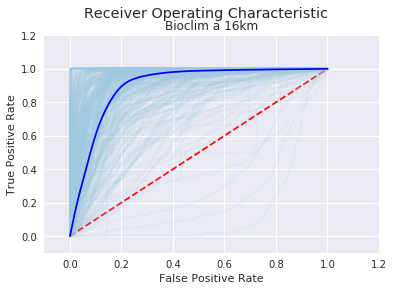

In [593]:
plot_rocs_var(sdms16_abio_df, 'Bioclim a 16km')

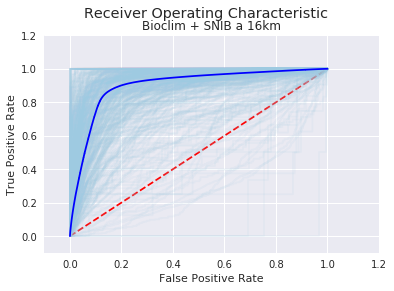

In [597]:
plot_rocs_var(sdms16_snib_df, 'Bioclim + SNIB a 16km')

In [596]:
def transform_variables(df):
    df['log(occ)'] = np.log2(df.occ)
    df['log(auc)'] = -np.log2(1 - 0.99999*df.auc)
    df['log(iucn)'] = np.log2(df.iucn_cells)
    
    return df
auc16_snib_df = transform_variables(auc16_snib_df)
auc16_abio_df = transform_variables(auc16_abio_df)

## plot_scatter

In [615]:
def plot_scatter(df, x, y):
    g = sns.JointGrid(x=x, y=y, data=df, size=10, )
    g = g.plot_joint(sns.regplot,
                     color="#008837", scatter=True, n_boot=25, lowess=True,
                     line_kws={"color": "r", "alpha": 0.7, "lw": 5,
                               'label': 'Locally Weighted Linear Regression'})
    g = g.annotate(stats.spearmanr)
    g.ax_joint.legend()

    plt.plot((-1, 12), (0.9, 0.9), c=".2", ls="--")
    plt.plot((-1, 12), (0.75, 0.75), c=".2", ls="--")
    plt.plot((-1, 12), (0.6, 0.6), c=".2", ls="--")

    g = g.plot_joint(sns.kdeplot, zorder=0, n_levels=5)
    g = g.plot_marginals(sns.distplot, kde=True, color="g", rug=True, bins=30)

    g.ax_joint.xaxis.set_major_formatter(
        tck.FuncFormatter(lambda x, pos: '{:0.1f}'.format(2**x)))



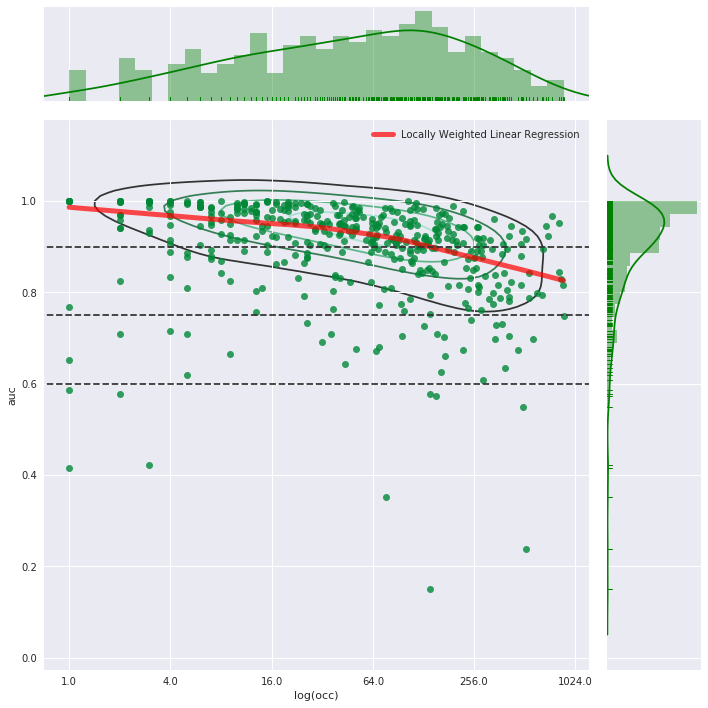

In [616]:
plot_scatter(auc16_abio_df, 'log(occ)', 'auc')

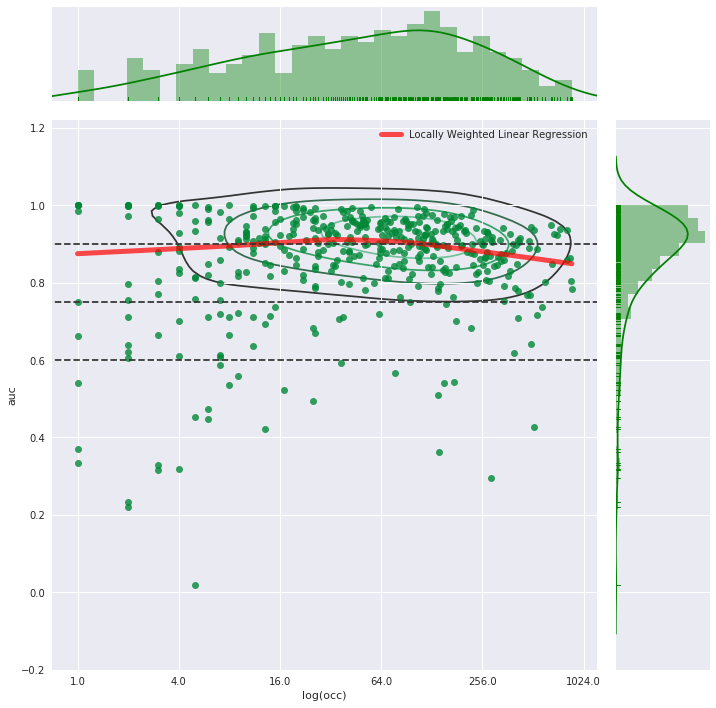

In [617]:
plot_scatter(auc16_snib_df, 'log(occ)', 'auc')

In [605]:
auc16_abio_df.describe()

,auc,iucn_cells,occ,log(occ),log(auc),log(iucn)
count,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,0.895314,1655.240275,116.656751,5.445599,4.392507,8.809281
std,0.111586,2181.101046,158.357615,2.326669,2.669018,3.119887
min,0.149520,1.000000,1.000000,0.000000,0.233648,0.000000
25%,0.864534,141.000000,13.000000,3.700440,2.883905,7.139551
50%,0.924459,766.000000,51.000000,5.672425,3.726423,9.581201
75%,0.969379,2285.000000,151.000000,7.238405,5.028876,11.157978
max,1.000000,9792.000000,872.000000,9.768184,16.609640,13.257388


In [606]:
auc16_snib_df.describe()

,auc,iucn_cells,occ,log(occ),log(auc),log(iucn)
count,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,0.859990,1655.240275,116.656751,5.445599,3.783573,8.809281
std,0.142161,2181.101046,158.357615,2.326669,2.435696,3.119887
min,0.018974,1.000000,1.000000,0.000000,0.027636,0.000000
25%,0.826986,141.000000,13.000000,3.700440,2.530969,7.139551
50%,0.902089,766.000000,51.000000,5.672425,3.352249,9.581201
75%,0.947206,2285.000000,151.000000,7.238405,4.243214,11.157978
max,1.000000,9792.000000,872.000000,9.768184,16.609640,13.257388


In [628]:
tables = pd.read_excel('Mapas Geoprtal Mamiferos.xlsx', sheet_name=[
                       'Especies Riesgo Geoportal', 'Distribucion Potencial Geoporta'])
maps_geoportal = pd.concat(tables)
maps_geoportal['binomial'] = maps_geoportal[u'Título del mapa'].apply(
    lambda x: ' '.join(x.split(' ')[:2]))
maps_geoportal = maps_geoportal.rename(index=str, columns={
                                       u'Título del mapa': "nom_mapa", "Nombre de shape": "shapefile"})
maps_geoportal = maps_geoportal[maps_geoportal.shapefile.str.contains('_AGW')]

In [884]:
maps_test = maps_geoportal

In [885]:
geoportal_shapes = []
for idx, row in maps_test.iterrows():
    shape_df = gpd.read_file(
        "data/Geoportal/{}.shp".format(row.shapefile.lower(), row.shapefile.lower()))
    if not row.binomial:
        print(row)
    shape_df['species'] = row.binomial
    geoportal_shapes.append(shape_df)

In [886]:
geoportal_gdfs = gpd.pd.concat(geoportal_shapes)
geoportal_cells = get_grid_iucn_intersection(
    grid_dir='grids/', analysis_res=16, iucn_shp=geoportal_gdfs)
geoportal_cells.loc[:, 'geop_presence'] = 1
geoportal_cells = geoportal_cells[geoportal_cells.species.notnull()]
geoportal_cells = geoportal_cells.loc[:, [
    'species', 'gridid', 'geop_presence']].drop_duplicates()

In [891]:
geop_species = geoportal_cells.species.unique()

In [893]:
merged = sdms16_abio_df.merge(geoportal_cells, on=['gridid', 'species'], how='left')

In [894]:
for sp in geop_species:
    merged.loc[merged.species == sp,
               'geop_presence'] = merged.loc[merged.species == sp, 'geop_presence'].fillna(0)

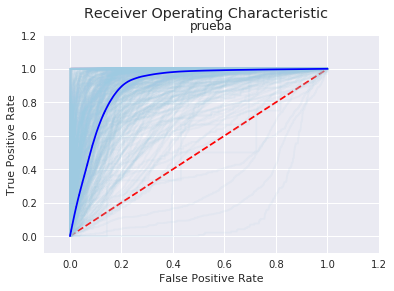

In [897]:
plot_rocs_var(merged,'prueba')

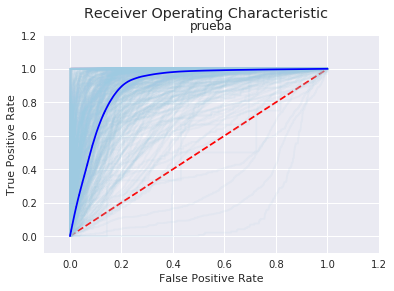

In [898]:
plot_rocs_var(merged,'prueba', truth_col='geop_presence')

In [ ]:
auc16_abio_geop_df = get_auc_occ_df(merged, 16, truth_col='geop_presence')

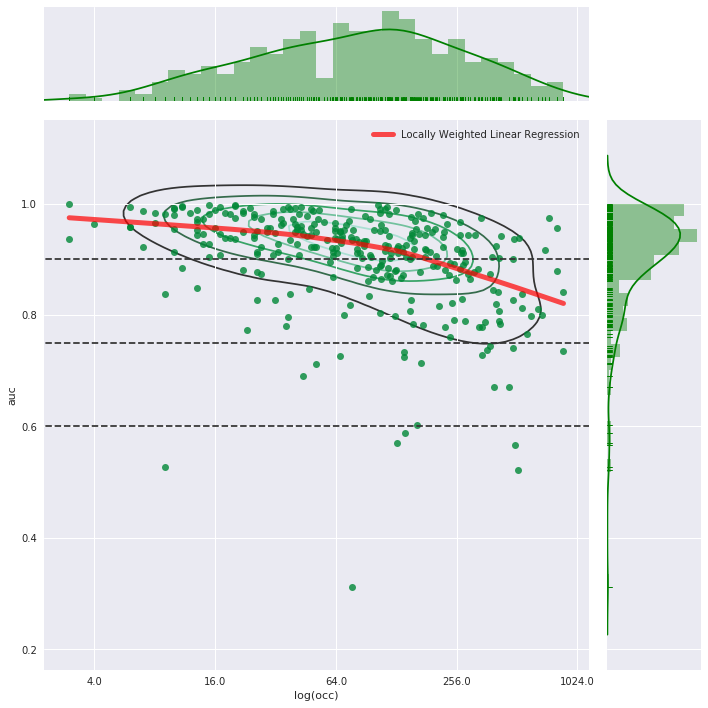

In [922]:
plot_scatter(auc16_abio_geop_df, 'log(occ)', 'auc')

In [924]:
df = auc16_abio_geop_df.dropna(how='any',axis=0) 

In [934]:
df.head()

,auc,iucn_cells,name,occ,log(occ),log(auc),log(iucn)
0,0.971434,239.0,Alouatta palliata,52,5.700440,5.129076,7.900867
1,0.950807,463.0,Ammospermophilus harrisii,26,4.700440,4.345110,8.854868
2,0.967054,565.0,Ammospermophilus interpres,13,3.700440,4.923325,9.142107
3,0.976777,599.0,Ammospermophilus leucurus,151,7.238405,5.427697,9.226412
4,0.942987,3867.0,Anoura geoffroyi,266,8.055282,4.132335,11.916999


In [925]:
df.describe()

,auc,iucn_cells,occ,log(occ),log(auc),log(iucn)
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.901936,2095.376206,145.864952,6.303483,3.982349,10.030771
std,0.090695,2226.128606,164.367491,1.727209,1.620260,2.029504
min,0.312302,6.000000,3.000000,1.584963,0.540146,2.584963
25%,0.876825,496.500000,34.500000,5.108373,3.021123,8.955632
50%,0.923792,1284.000000,88.000000,6.459432,3.713733,10.326429
75%,0.958096,2870.500000,185.000000,7.531192,4.576460,11.487063
max,1.000000,9757.000000,872.000000,9.768184,16.609640,13.252222


In [957]:
sdms16_snib_filtered_df = sdms16_snib_df.where(sdms16_snib_df.species.isin(geop_species))
sdms16_abio_filtered_df = sdms16_abio_df.where(sdms16_abio_df.species.isin(geop_species))

In [947]:
sdms16_snib_df.describe()

,confussion,gridid,pred,presence,tscore
count,4.364673e+06,4.364673e+06,4.364673e+06,4.364673e+06,4.364673e+06
mean,5.831910e-01,1.366241e+04,2.517389e-01,1.657260e-01,-4.001951e+02
std,1.065352e+00,5.974393e+03,4.340121e-01,3.718346e-01,1.006050e+03
min,0.000000e+00,1.940000e+02,0.000000e+00,0.000000e+00,-2.424786e+04
25%,0.000000e+00,9.618000e+03,0.000000e+00,0.000000e+00,-4.965412e+02
50%,0.000000e+00,1.383000e+04,0.000000e+00,0.000000e+00,-1.826965e+02
75%,1.000000e+00,1.753200e+04,1.000000e+00,0.000000e+00,1.181440e+00
max,3.000000e+00,2.677000e+04,1.000000e+00,1.000000e+00,1.323512e+04


In [948]:
filtered_snib.describe()

,confussion,gridid,pred,presence,tscore
count,3.099330e+06,3.099330e+06,3.099330e+06,3.099330e+06,3.099330e+06
mean,7.323244e-01,1.366249e+04,3.130080e-01,2.096582e-01,-2.983624e+02
std,1.153180e+00,5.974317e+03,4.637176e-01,4.070647e-01,9.625201e+02
min,0.000000e+00,1.940000e+02,0.000000e+00,0.000000e+00,-2.424786e+04
25%,0.000000e+00,9.619000e+03,0.000000e+00,0.000000e+00,-3.806655e+02
50%,0.000000e+00,1.383100e+04,0.000000e+00,0.000000e+00,-1.190895e+02
75%,1.000000e+00,1.753200e+04,1.000000e+00,0.000000e+00,3.041802e+01
max,3.000000e+00,2.677000e+04,1.000000e+00,1.000000e+00,1.196921e+04


In [958]:
sdms16_snib_filtered_df = sdms16_snib_filtered_df.merge(geoportal_cells, on=['gridid', 'species'], how='left')
sdms16_abio_filtered_df = sdms16_abio_filtered_df.merge(geoportal_cells, on=['gridid', 'species'], how='left')

sdms16_snib_filtered_df.geop_presence = sdms16_snib_filtered_df.geop_presence.fillna(0)
sdms16_abio_filtered_df.geop_presence = sdms16_abio_filtered_df.geop_presence.fillna(0)

In [1092]:
sdms16_snib_filtered_df = sdms16_snib_filtered_df.dropna()
sdms16_abio_filtered_df = sdms16_abio_filtered_df.dropna()


In [1093]:
auc16_snib_geop_df = get_auc_occ_df(sdms16_snib_filtered_df, 16, truth_col='geop_presence')
auc16_abio_geop_df = get_auc_occ_df(sdms16_abio_filtered_df, 16, truth_col='geop_presence')

In [1094]:
auc16_snib_df = get_auc_occ_df(sdms16_snib_filtered_df, 16, truth_col='presence')
auc16_abio_df = get_auc_occ_df(sdms16_abio_filtered_df, 16, truth_col='presence')

In [998]:
auc16_abio_geop_df['truth_source'] = 'CONABIO'
auc16_snib_geop_df['truth_source'] = 'CONABIO'

In [999]:
auc16_abio_df['truth_source'] = 'IUCN'
auc16_snib_df['truth_source'] = 'IUCN'

In [1000]:
auc16_abio_geop_df['covariates_set'] = 'Bioclim'
auc16_abio_df['covariates_set'] = 'Bioclim'

auc16_snib_geop_df['covariates_set'] = 'Bioclim+SNIB'
auc16_snib_df['covariates_set'] = 'Bioclim+SNIB'

aucs_df = pd.concat([auc16_abio_geop_df, auc16_snib_geop_df, auc16_abio_df, auc16_snib_df], sort=True)

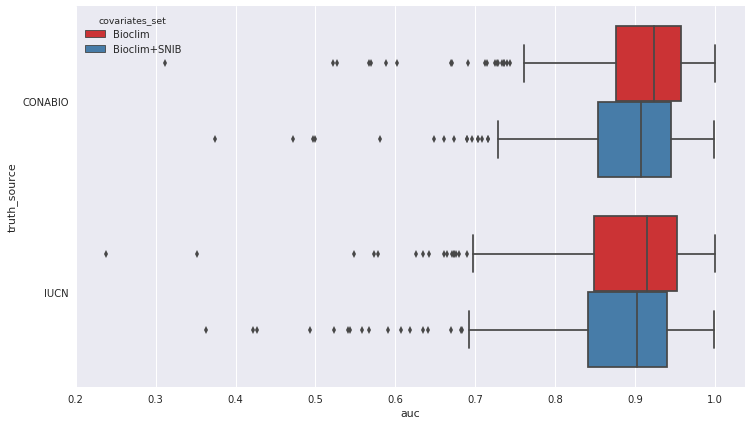

In [1046]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(data=aucs_df, x="auc", y="truth_source", hue="covariates_set", 
               palette="Set1",  ax=ax)

In [1002]:
aucs_df.describe()

,auc,iucn_cells,occ
count,1244.000000,1244.000000,1244.000000
mean,0.887537,2092.382637,145.864952
std,0.096505,2246.647780,164.169019
min,0.237901,4.000000,3.000000
25%,0.852215,482.000000,34.000000
50%,0.912785,1237.000000,88.000000
75%,0.950243,2887.000000,188.000000
max,1.000000,9792.000000,872.000000


In [1003]:
aucs_df = transform_variables(aucs_df)

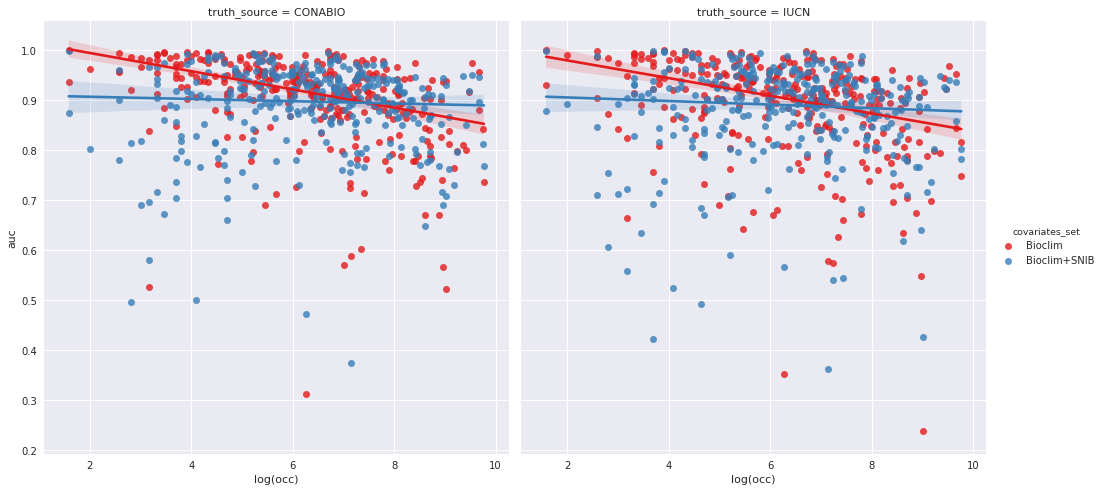

In [1052]:
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.lmplot(data=aucs_df, x='log(occ)', y='auc', col="truth_source", size=7,
               hue="covariates_set", scatter=True, palette="Set1", truncate=True, robust=True)


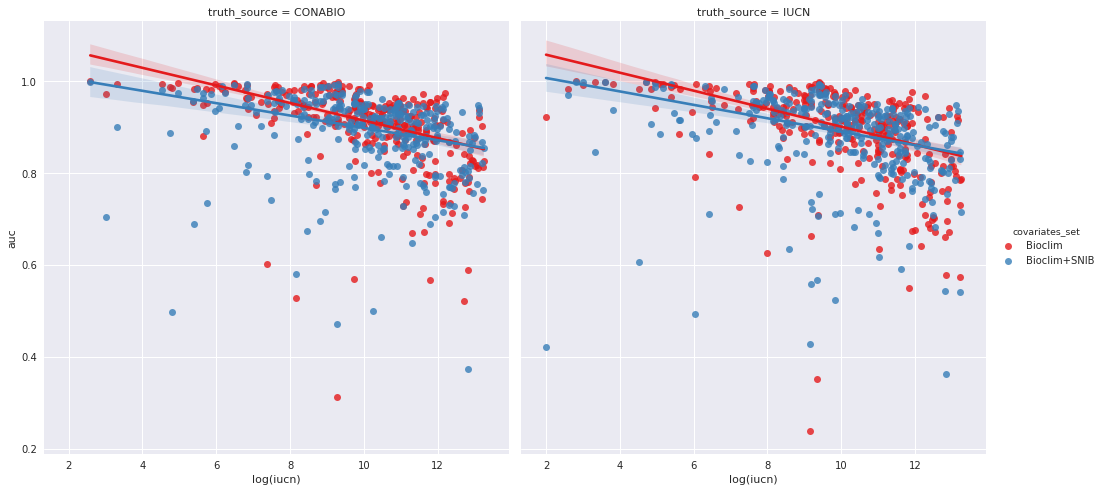

In [1050]:
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.lmplot(data=aucs_df, x='log(iucn)', y='auc', col="truth_source", size=7,
               hue="covariates_set", scatter=True, n_boot=1000, palette="Set1", truncate=True, robust=True)


In [1058]:
aucs_df.describe()

,auc,iucn_cells,occ,log(occ),log(auc),log(iucn)
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,0.887537,2092.382637,145.864952,6.303483,3.720612,9.982654
std,0.096505,2246.647780,164.169019,1.725124,1.533394,2.107366
min,0.237901,4.000000,3.000000,1.584963,0.391944,2.000000
25%,0.852215,482.000000,34.000000,5.087463,2.758344,8.912889
50%,0.912785,1237.000000,88.000000,6.459432,3.519126,10.272622
75%,0.950243,2887.000000,188.000000,7.554589,4.328685,11.495355
max,1.000000,9792.000000,872.000000,9.768184,16.609640,13.257388


In [1053]:
aucs_df.head()

,auc,covariates_set,iucn_cells,name,occ,truth_source,log(occ),log(auc),log(iucn)
0,0.971434,Bioclim,239.0,Alouatta palliata,52,CONABIO,5.700440,5.129076,7.900867
1,0.950807,Bioclim,463.0,Ammospermophilus harrisii,26,CONABIO,4.700440,4.345110,8.854868
2,0.967054,Bioclim,565.0,Ammospermophilus interpres,13,CONABIO,3.700440,4.923325,9.142107
3,0.976777,Bioclim,599.0,Ammospermophilus leucurus,151,CONABIO,7.238405,5.427697,9.226412
4,0.942987,Bioclim,3867.0,Anoura geoffroyi,266,CONABIO,8.055282,4.132335,11.916999


In [1109]:
aucs_df.sort_values(by='auc', ascending=True)[:20]

,auc,covariates_set,iucn_cells,name,occ,truth_source,log(occ),log(auc),log(iucn)
274,0.237901,Bioclim,567.0,Sigmodon hispidus,520,IUCN,9.022368,0.391944,9.147205
107,0.312302,Bioclim,622.0,Lasiurus borealis,77,CONABIO,6.266787,0.540146,9.280771
107,0.351906,Bioclim,655.0,Lasiurus borealis,77,IUCN,6.266787,0.625717,9.355351
111,0.362451,Bioclim+SNIB,7323.0,Lasiurus xanthinus,141,IUCN,7.139551,0.649384,12.838219
111,0.374173,Bioclim+SNIB,7288.0,Lasiurus xanthinus,141,CONABIO,7.139551,0.676156,12.831307
199,0.421604,Bioclim+SNIB,4.0,Peromyscus bullatus,13,IUCN,3.700440,0.789859,2.000000
274,0.426965,Bioclim+SNIB,567.0,Sigmodon hispidus,520,IUCN,9.022368,0.803294,9.147205
107,0.471953,Bioclim+SNIB,622.0,Lasiurus borealis,77,CONABIO,6.266787,0.921249,9.280771
135,0.493214,Bioclim+SNIB,66.0,Molossus aztecus,25,IUCN,4.643856,0.980538,6.044394
156,0.497162,Bioclim+SNIB,28.0,Nelsonia goldmani,7,CONABIO,2.807355,0.991820,4.807355


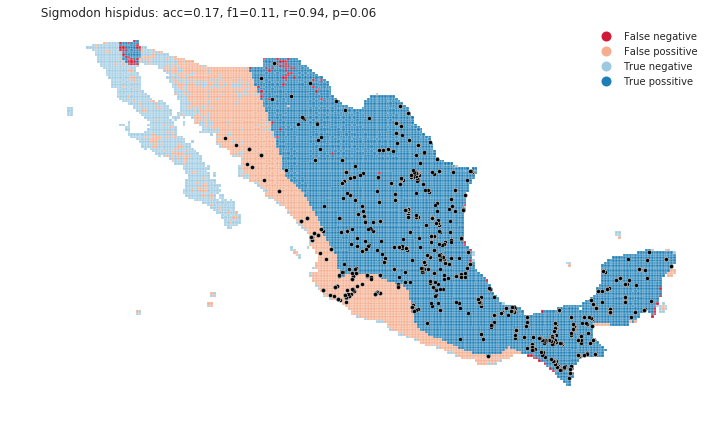

In [1103]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Sigmodon hispidus')
plot_confusion_map(species_sdm, name='Sigmodon hispidus', ax=ax, confussion_col='geop_confussion_labels')

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df'species')
species_sdm = species_sdm.get_group('Sigmodon hispidus')
plot_confusion_map(species_sdm, name='Sigmodon hispidus', ax=ax)

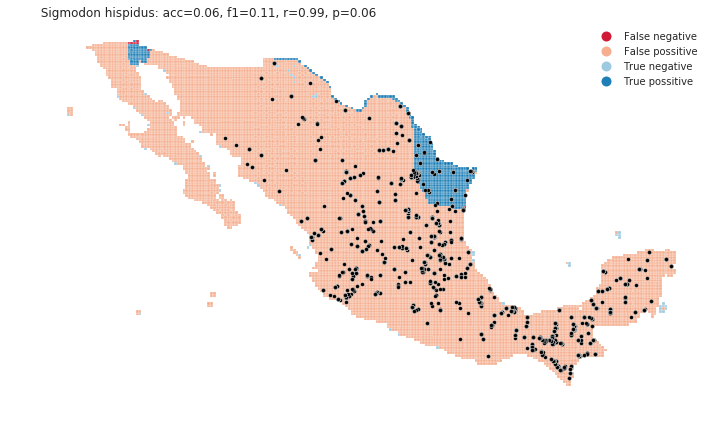

In [1074]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_abio_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Sigmodon hispidus')
plot_confusion_map(species_sdm, name='Sigmodon hispidus', ax=ax)

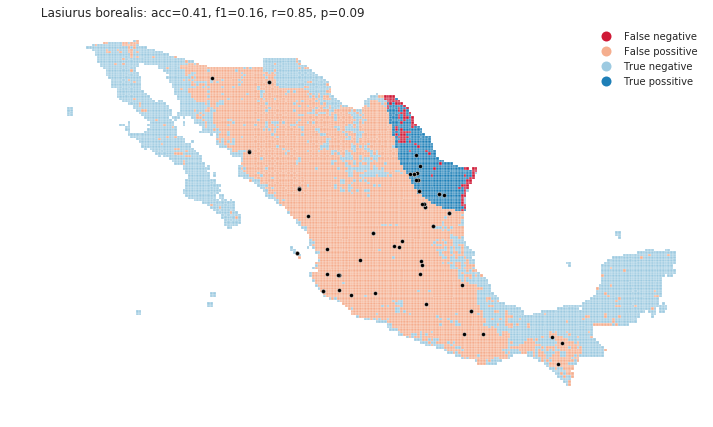

In [1075]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Lasiurus borealis')
plot_confusion_map(species_sdm, name='Lasiurus borealis', ax=ax)

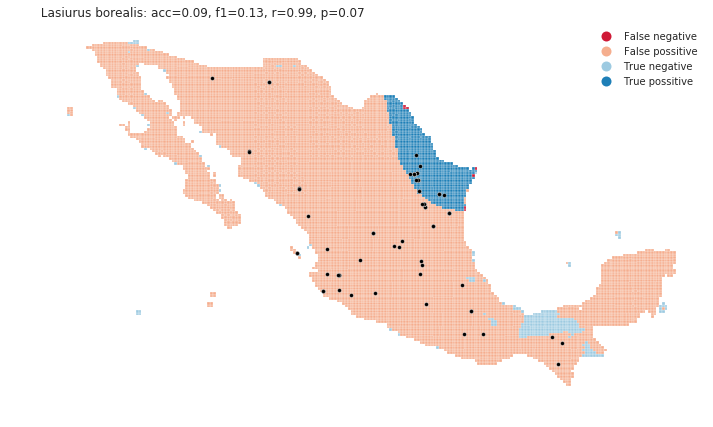

In [1076]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_abio_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Lasiurus borealis')
plot_confusion_map(species_sdm, name='Lasiurus borealis', ax=ax)

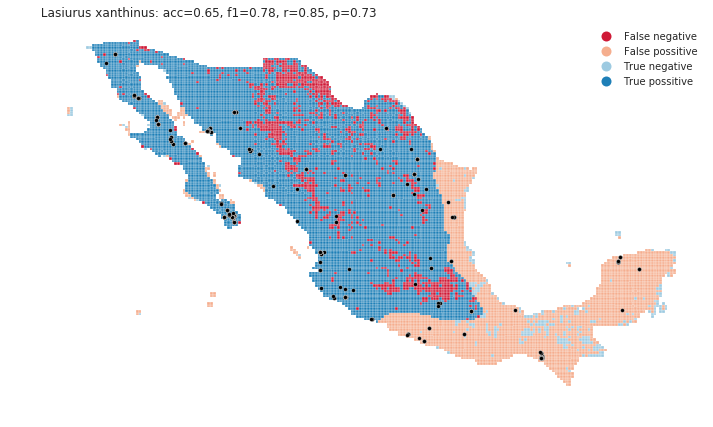

In [1077]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Lasiurus xanthinus')
plot_confusion_map(species_sdm, name='Lasiurus xanthinus', ax=ax)

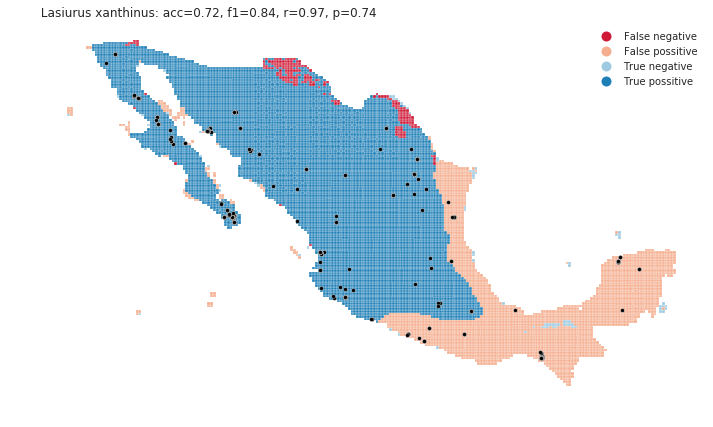

In [1078]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_abio_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Lasiurus xanthinus')
plot_confusion_map(species_sdm, name='Lasiurus xanthinus', ax=ax)

In [1107]:
species_sdm[:10]

,confussion,confussion_labels,geometry,gridid,pred,presence,species,tscore,geop_presence,geop_confussion,geop_confussion_labels
3806095,1.0,False possitive,POLYGON ((-94.28717222118497 17.13031704754859...,21554.0,1.0,0.0,Sigmodon hispidus,595.649275,1.0,3.0,True possitive
3806096,1.0,False possitive,POLYGON ((-94.14344177572583 17.13031704754859...,21556.0,1.0,0.0,Sigmodon hispidus,227.349275,1.0,3.0,True possitive
3806097,1.0,False possitive,POLYGON ((-94.28717222118497 17.26762035792294...,21557.0,1.0,0.0,Sigmodon hispidus,148.159275,1.0,3.0,True possitive
3806098,1.0,False possitive,POLYGON ((-94.28717222118497 17.40482146607723...,21558.0,1.0,0.0,Sigmodon hispidus,666.499275,1.0,3.0,True possitive
3806099,1.0,False possitive,POLYGON ((-94.14344177572583 17.26762035792294...,21559.0,1.0,0.0,Sigmodon hispidus,103.109275,1.0,3.0,True possitive
3806100,1.0,False possitive,POLYGON ((-94.14344177572583 17.40482146607723...,21560.0,1.0,0.0,Sigmodon hispidus,748.299275,1.0,3.0,True possitive
3806101,1.0,False possitive,POLYGON ((-93.99971133026672 17.13031704754859...,21562.0,1.0,0.0,Sigmodon hispidus,47.439275,1.0,3.0,True possitive
3806102,1.0,False possitive,POLYGON ((-93.85598088480759 17.13031704754859...,21564.0,1.0,0.0,Sigmodon hispidus,865.619275,1.0,3.0,True possitive
3806103,1.0,False possitive,POLYGON ((-93.99971133026672 17.26762035792294...,21565.0,1.0,0.0,Sigmodon hispidus,37.599275,1.0,3.0,True possitive
3806104,1.0,False possitive,POLYGON ((-93.99971133026672 17.40482146607723...,21566.0,1.0,0.0,Sigmodon hispidus,31.559275,1.0,3.0,True possitive


In [1099]:
labels = {
    0: 'True negative',
    1: 'False possitive',
    2: 'False negative',
    3: 'True possitive'
}

sdms16_abio_filtered_df['geop_confussion'] = 2 * \
    sdms16_abio_filtered_df['geop_presence'] + sdms16_abio_filtered_df['pred']

sdms16_abio_filtered_df['geop_confussion_labels'] = [labels[conf_val]
                                                     for conf_val in sdms16_abio_filtered_df['geop_confussion']]

In [1101]:
sdms16_snib_filtered_df['geop_confussion'] = 2 * \
    sdms16_snib_filtered_df['geop_presence'] + sdms16_snib_filtered_df['pred']

sdms16_snib_filtered_df['geop_confussion_labels'] = [labels[conf_val]
                                                     for conf_val in sdms16_snib_filtered_df['geop_confussion']]

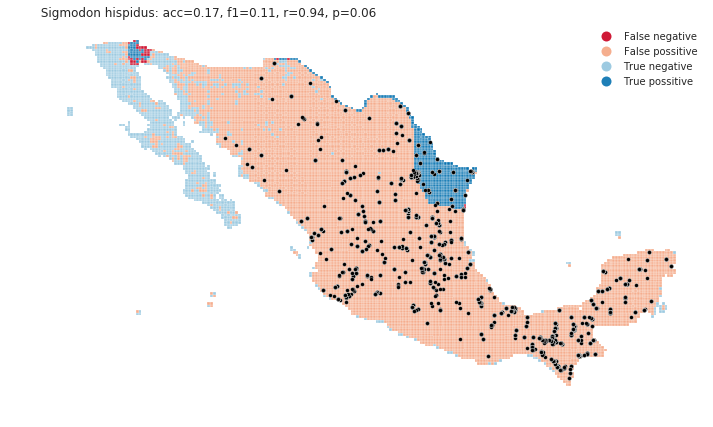

In [1106]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Sigmodon hispidus')
plot_confusion_map(species_sdm, name='Sigmodon hispidus', ax=ax)

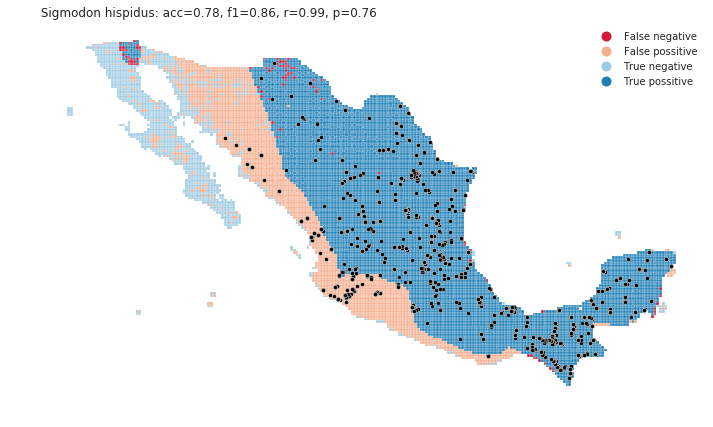

In [1105]:
f, ax = plt.subplots(1, figsize=(12, 7))
species_sdm = sdms16_snib_filtered_df.groupby('species')
species_sdm = species_sdm.get_group('Sigmodon hispidus')
plot_confusion_map(species_sdm, name='Sigmodon hispidus',
                   ax=ax,
                   confussion_col='geop_confussion_labels',
                   presence_col='geop_presence')